In [5]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("Book Genome Project") \
    .getOrCreate()


In [ ]:
ratings_df = spark.read.json("book-genome\\book_dataset\\raw\\ratings.json")
ratings_df.printSchema()
ratings_df.limit(100).show(truncate=False)




root
 |-- item_id: long (nullable = true)
 |-- rating: long (nullable = true)
 |-- user_id: long (nullable = true)

+--------+------+-------+
|item_id |rating|user_id|
+--------+------+-------+
|41335427|5     |0      |
|41335427|3     |1      |
|41335427|5     |2      |
|41335427|5     |3      |
|41335427|5     |4      |
|41335427|4     |5      |
|41335427|5     |6      |
|41335427|5     |7      |
|41335427|5     |8      |
|41335427|5     |9      |
|41335427|5     |10     |
|41335427|5     |11     |
|41335427|5     |12     |
|41335427|5     |13     |
|41335427|5     |14     |
|41335427|5     |15     |
|41335427|4     |16     |
|41335427|3     |17     |
|41335427|5     |18     |
|41335427|4     |19     |
+--------+------+-------+
only showing top 20 rows



In [8]:
# We get the average, min, max, count of ratings overall:
from pyspark.sql.functions import avg, min, max, count

ratings_df.agg(
    avg("rating").alias("avg_rating"),
    min("rating").alias("min_rating"),
    max("rating").alias("max_rating"),
    count("*").alias("total_ratings")
).show()


+------------------+----------+----------+-------------+
|        avg_rating|min_rating|max_rating|total_ratings|
+------------------+----------+----------+-------------+
|3.9557961952049583|         1|         5|      5152656|
+------------------+----------+----------+-------------+



In [12]:
# Next we do a rating distribution to See how many users gave each rating.
ratings_df.groupBy("rating").count().orderBy("rating").show()


+------+-------+
|rating|  count|
+------+-------+
|     1| 156250|
|     2| 359785|
|     3| 974773|
|     4|1726522|
|     5|1935326|
+------+-------+



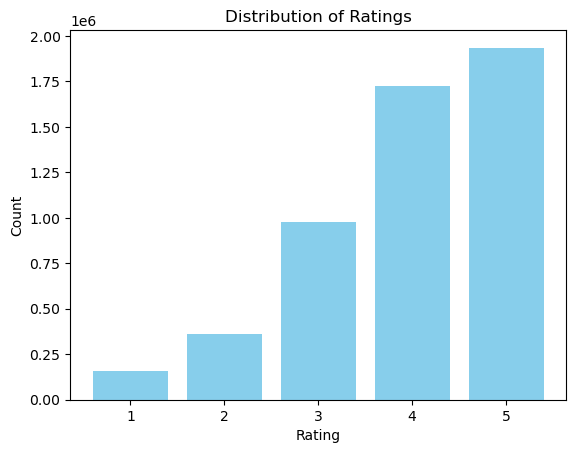

In [13]:
import matplotlib.pyplot as plt

rating_dist = ratings_df.groupBy("rating").count().toPandas()

plt.bar(rating_dist["rating"], rating_dist["count"], color="skyblue")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.xticks(range(1, 6))
plt.show()


In [15]:
#Now we gwt get average rating and number of ratings per item_id (book)
book_stats = ratings_df.groupBy("item_id").agg(
    avg("rating").alias("avg_rating"),
    count("rating").alias("rating_count")
)
book_stats.orderBy("avg_rating", ascending=False).show(50)


+--------+------------------+------------+
| item_id|        avg_rating|rating_count|
+--------+------------------+------------+
|26518929| 4.826568265682657|         271|
|52922245| 4.818604651162791|         215|
|49704739| 4.801546391752577|         388|
|41343043| 4.788571428571428|         175|
| 2962492| 4.786963434022257|         629|
|28323940|4.7801608579088475|         746|
|26419682|  4.77027027027027|         296|
|47472732|              4.77|         300|
|51859542|           4.76875|         160|
|16482835| 4.767676767676767|        1386|
|49728679| 4.755274261603375|         237|
|19123949| 4.755208333333333|         192|
|48123755| 4.752631578947368|         190|
|26654514| 4.752577319587629|         194|
|15064476| 4.751633986928105|         306|
|51168550|          4.746875|         320|
|51281303| 4.741496598639456|         294|
|49570675|4.7407407407407405|         243|
|49638190| 4.740498442367601|        3210|
|41452434| 4.739010989010989|         364|
|25040772| 

In [ ]:
# We then join this with book metadata to see book titles instead of just IDs
# First we Load metadata .
metadata_df = spark.read.json("book-genome/book_dataset/raw/metadata.json")

# Check schemas
metadata_df.printSchema()
book_stats.printSchema()

# Ensure item_id exists in both before joining
joined_df = book_stats.join(metadata_df, on="item_id", how="inner")

# Select desired columns and show sorted results
joined_df.select("title", "avg_rating", "rating_count") \
    .orderBy("avg_rating", ascending=False) \
    .show(10, truncate=False)


root
 |-- authors: string (nullable = true)
 |-- description: string (nullable = true)
 |-- img: string (nullable = true)
 |-- item_id: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- year: long (nullable = true)

root
 |-- item_id: long (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- rating_count: long (nullable = false)

+----------------------------------------------------+------------------+------------+
|title                                               |avg_rating        |rating_count|
+----------------------------------------------------+------------------+------------+
|Lovely Trigger (Tristan & Danika, #3)               |4.826568265682657 |271         |
|The Gravity of Us (Elements, #4)                    |4.818604651162791 |215         |
|March: Book Three (March, #3)                       |4.801546391752577 |388         |
|Long Way Down (Calloway Sisters, #4; Addicted, 

In [19]:
#Also we checked to see most rated books 
book_stats.orderBy("rating_count", ascending=False).show()


+--------+------------------+------------+
| item_id|        avg_rating|rating_count|
+--------+------------------+------------+
|16827462| 4.401268538382614|       21442|
| 2792775| 4.414875365829045|       19818|
|13306276|  3.84711450729927|       17536|
|13155899| 4.153990439886247|       16527|
|41107568|3.6560544591899884|       14543|
| 8812783|  3.89840830449827|       14450|
|  878368| 4.489452790534755|       12847|
| 6171458| 4.329810407422348|       12395|
|48765776| 3.594745027420807|       12217|
|17763198| 4.361732428583396|       11937|
|15732562|  2.78102821533668|       11554|
|15524549|3.3899237182898707|       11274|
|21825181| 4.326118067978533|       11180|
|17225055| 4.208835341365462|       10956|
|14863741| 4.279639773465788|       10771|
| 4640799| 4.602253521126761|       10650|
|14345371| 3.688744221152939|       10599|
|15545385| 4.188663040366447|       10479|
| 3212258| 3.447479197258933|       10215|
|21861351| 4.224654494098658|        9913|
+--------+-

In [20]:
#total rating per user
ratings_df.groupBy("user_id").count().orderBy("count", ascending=False).show()


+-------+-----+
|user_id|count|
+-------+-----+
|   3782| 1425|
|     92| 1067|
|  24042|  993|
|   5764|  965|
|    394|  955|
|  22100|  876|
|  18616|  870|
|    656|  869|
|  33120|  866|
|    885|  859|
|   1194|  831|
|   8057|  814|
|  16848|  786|
| 181209|  784|
|  14382|  782|
|   2719|  780|
|  80663|  765|
|  25161|  755|
|  62005|  749|
|  40542|  743|
+-------+-----+
only showing top 20 rows



In [21]:
# Check for Ratings correlated with metadata by joining Ratings Correlated with Metadata
ratings_with_year = ratings_df.join(metadata_df.select("item_id", "year"), on="item_id")
ratings_with_year.groupBy("year").agg(avg("rating").alias("avg_rating")).orderBy("year").show()


+----+------------------+
|year|        avg_rating|
+----+------------------+
|   0|3.9113621625311445|
|1912| 4.270769230769231|
|1936|  4.47979797979798|
|1950| 4.152073732718894|
|1952| 4.027237354085603|
|1957| 3.457510729613734|
|1959|3.8757062146892656|
|1961|  4.35754189944134|
|1962| 4.331632653061225|
|1963| 4.196145124716553|
|1964| 4.142329020332717|
|1969|3.7400881057268722|
|1971| 4.176165803108808|
|1972|3.8176007866273354|
|1973|3.8639749117992945|
|1974| 4.176165803108808|
|1975| 4.277992277992278|
|1976|3.4604604604604603|
|1977|3.6954206602768904|
|1978| 3.994034302759135|
+----+------------------+
only showing top 20 rows



In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, row_number
from pyspark.sql.window import Window

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("BookRankAnalysis") \
    .getOrCreate()

# Load ratings data (replace this with the correct path or source of your ratings data)
ratings_df = spark.read.json("book-genome\\book_dataset\\raw\\ratings.json")

# Check the schema to ensure the ratings_df has the right columns
ratings_df.printSchema()

# Define the window specification for ranking
window_spec = Window.partitionBy("item_id").orderBy(col("rating").desc())

# Rank the books based on the rating (or review_count)
ranked_books = ratings_df.withColumn("rank", row_number().over(window_spec))

# Show top-ranked books (e.g., top 3 ranked books) - Fixing column reference
ranked_books.select("item_id", "rating", "user_id", "rank") \
    .filter(col("rank") <= 3) \
    .show(truncate=False)


root
 |-- item_id: long (nullable = true)
 |-- rating: long (nullable = true)
 |-- user_id: long (nullable = true)

+-------+------+-------+----+
|item_id|rating|user_id|rank|
+-------+------+-------+----+
|115    |5     |5423   |1   |
|115    |5     |3681   |2   |
|115    |5     |30338  |3   |
|387    |5     |40267  |1   |
|387    |5     |40274  |2   |
|387    |5     |40283  |3   |
|423    |5     |16654  |1   |
|423    |5     |41049  |2   |
|423    |5     |42508  |3   |
|434    |5     |114259 |1   |
|434    |5     |87604  |2   |
|434    |5     |65399  |3   |
|466    |5     |32770  |1   |
|466    |5     |146574 |2   |
|466    |5     |113051 |3   |
|505    |5     |13101  |1   |
|505    |5     |13116  |2   |
|505    |5     |41084  |3   |
|574    |5     |15     |1   |
|574    |5     |18076  |2   |
+-------+------+-------+----+
only showing top 20 rows



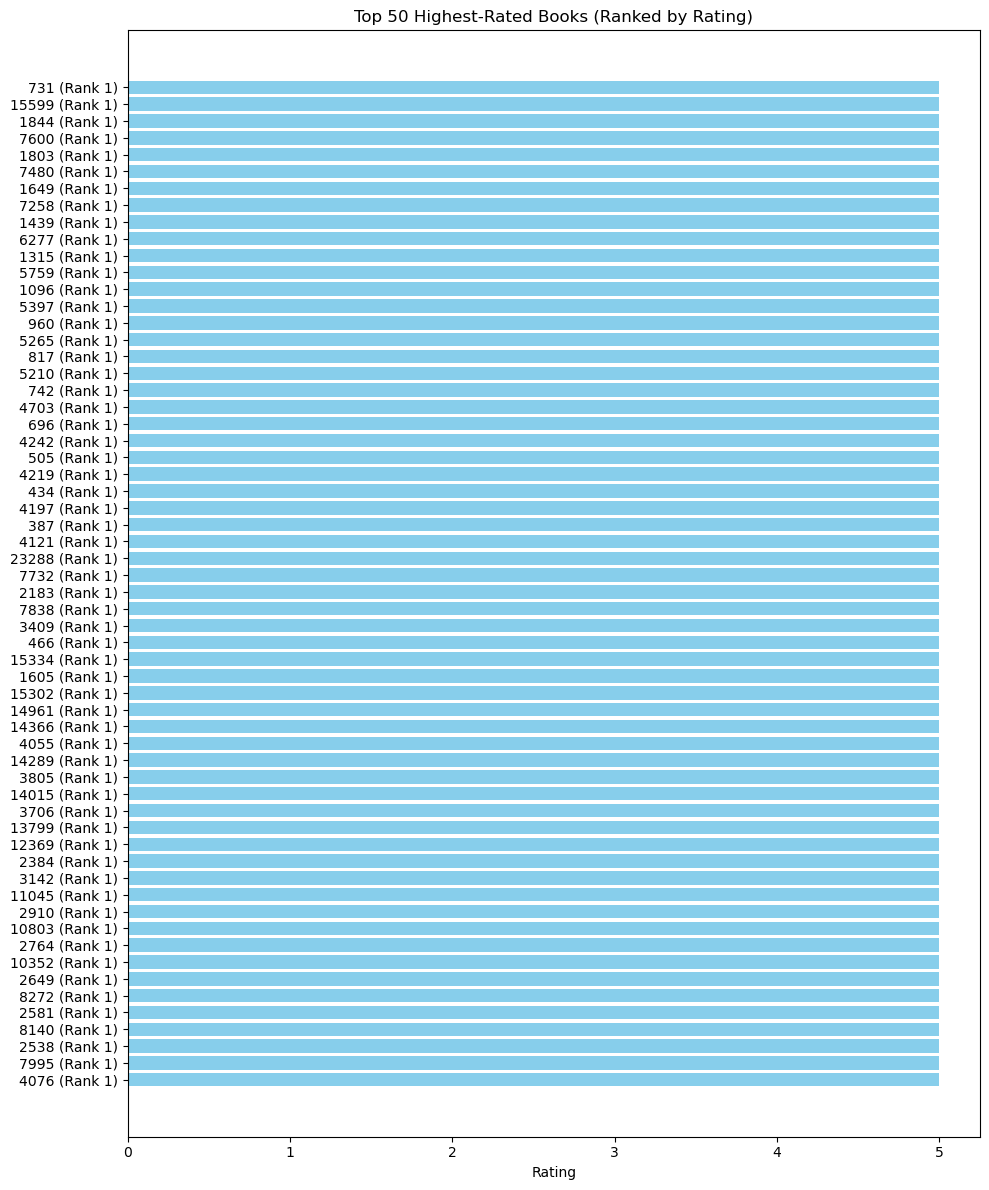

In [7]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Prepare Pandas data - Filter the top 3 highest-rated books based on "rating"
top_rated_books_pd = ranked_books.filter(col("rank") <= 3) \
    .select("item_id", "rating", "rank") \
    .orderBy("rank") \
    .limit(60) \
    .toPandas()

# Create a combined label for visualization
top_rated_books_pd["label"] = top_rated_books_pd["item_id"].astype(str) + " (Rank " + top_rated_books_pd["rank"].astype(str) + ")"

# Sort the data by rating in ascending order (or descending based on your requirement)
top_rated_books_pd = top_rated_books_pd.sort_values("rating", ascending=True)

# Plot with matplotlib
plt.figure(figsize=(10, 12))
plt.barh(top_rated_books_pd["label"], top_rated_books_pd["rating"], color="skyblue")
plt.xlabel("Rating")
plt.title("Top 50 Highest-Rated Books (Ranked by Rating)")
plt.tight_layout()
plt.show()
